In [1]:
import os
import random
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
from himalaya.backend import set_backend

from compare_variance_residual.residual import residual_method
from compare_variance_residual.simulation import generate_dataset
from compare_variance_residual.variance_partitioning import variance_partitioning


def get_path(alphas, cv, n_targets):
    path = os.path.join("results", f"targets={n_targets}", f"cv={cv}",
                        f"alphas={alphas.min()},{alphas.max()},{len(alphas)}", "varying dimensions")
    os.makedirs(path, exist_ok=True)
    return path

In [2]:
def save_scores(d_list_list, scalars, n_targets, n_samples, noise_target, cv, alphas):
    path = get_path(alphas, cv, n_targets)
    for d_list in d_list_list:
        print(d_list)
        csv_path = os.path.join(path, f"scores_{d_list}.csv")
        scores = pd.DataFrame()
        if os.path.exists(csv_path):
            print("skipping, already exists")
            continue
        Xs, Y = generate_dataset(d_list, scalars, n_targets, n_samples, noise_target)
        print("data generated")
        x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score = variance_partitioning(
            Xs, Y, n_samples_train, alphas, cv)
        print("variance partitioning done")

        scores["x1_score"] = x1_score
        scores["x2_score"] = x2_score
        scores["vp_joint_score"] = joint_score
        scores["vp_shared_score"] = x1_and_x2_score
        scores["vp_x1_unique_score"] = vp_x1_unique_score
        scores["vp_x2_unique_score"] = vp_x2_unique_score
        del x1_score, x2_score, joint_score, x1_and_x2_score, vp_x1_unique_score, vp_x2_unique_score

        _, _, x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score = residual_method(
            Xs, Y, n_samples_train, alphas, cv)
        print("residual method done")
        scores["rm_x2_to_x1_score"] = np.concatenate(
            [x2_to_x1_score, np.full(len(rm_x1_unique_score) - len(x2_to_x1_score), np.nan)])
        scores["rm_x1_to_x2_score"] = np.concatenate(
            [x1_to_x2_score, np.full(len(rm_x1_unique_score) - len(x1_to_x2_score), np.nan)])
        scores["rm_x1_unique_score"] = rm_x1_unique_score
        scores["rm_x2_unique_score"] = rm_x2_unique_score
        del x2_to_x1_score, x1_to_x2_score, rm_x1_unique_score, rm_x2_unique_score
        del Xs, Y
        scores.to_csv(csv_path, index=False)

# Save scores for varying Dimensions

In [3]:
backend = set_backend("cupy", on_error="warn")
warnings.filterwarnings("ignore")
random.seed(42)

In [4]:
d_list = [100, 100, 100]
n_targets = 10000
n_samples_train = 10000
n_samples_test = 100
n_samples = n_samples_train + n_samples_test
noise_target = 0.1
scalars = [1 / 3, 1 / 3, 1 / 3]

cv = 10
alphas = np.logspace(-5, 5, 10)

In [5]:
varying_dim = np.logspace(1, 3, 3, dtype=int)

## Shared dimension

In [6]:
d_list_list = [[dim, d_list[1], d_list[2]] for dim in varying_dim]

In [7]:
save_scores(d_list_list, scalars, n_targets, n_samples, noise_target, cv, alphas)

[np.int64(10), 100, 100]
skipping, already exists
[np.int64(100), 100, 100]
skipping, already exists
[np.int64(1000), 100, 100]
data generated
variance partitioning done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0  0.461371  0.459514        0.874169         0.046716            0.414655   
1  0.535339  0.573399        0.895665         0.213072            0.322267   
2  0.568278  0.554833        0.878547         0.244565            0.323714   
3  0.375521  0.464975        0.875263        -0.034768            0.410289   
4  0.588965  0.537196        0.908395         0.217765            0.371200   

   vp_x2_unique_score  
0            0.412797  
1            0.360327  
2            0.310269  
3            0.499742  
4            0.319430  
residual method done


## Unique dimension

In [8]:
d_list_list = [[d_list[0], dim, d_list[2]] for dim in varying_dim]

In [9]:
save_scores(d_list_list, d_list, n_targets, n_samples, noise_target, cv, alphas)

[100, np.int64(10), 100]
data generated
variance partitioning done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0  0.549256  0.611021        0.922585         0.237692            0.311564   
1  0.540532  0.537617        0.883811         0.194338            0.346194   
2  0.642491  0.637364        0.913167         0.366688            0.275803   
3  0.615331  0.616610        0.894938         0.337003            0.278328   
4  0.535285  0.491975        0.880579         0.146682            0.388603   

   vp_x2_unique_score  
0            0.373329  
1            0.343279  
2            0.270676  
3            0.279607  
4            0.345293  
residual method done
[100, np.int64(100), 100]
data generated
variance partitioning done
   x1_score  x2_score  vp_joint_score  vp_shared_score  vp_x1_unique_score  \
0  0.563241  0.566870        0.897115         0.232996            0.330245   
1  0.551462  0.590797        0.876583         0.265676            0.285786 

# Plot scores

In [10]:
vp_x1_unique_predicted = []
vp_x2_unique_predicted = []
rm_x1_unique_predicted = []
rm_x2_unique_predicted = []

for d_list in d_list_list:
    scores = pd.read_csv(os.path.join(get_path(alphas, cv, n_targets), f"scores_{d_list}.csv"))
    vp_x1_unique_predicted.append(scores["vp_x1_unique_score"])
    vp_x2_unique_predicted.append(scores["vp_x2_unique_score"])
    rm_x1_unique_predicted.append(scores["rm_x1_unique_score"])
    rm_x2_unique_predicted.append(scores["rm_x2_unique_score"])

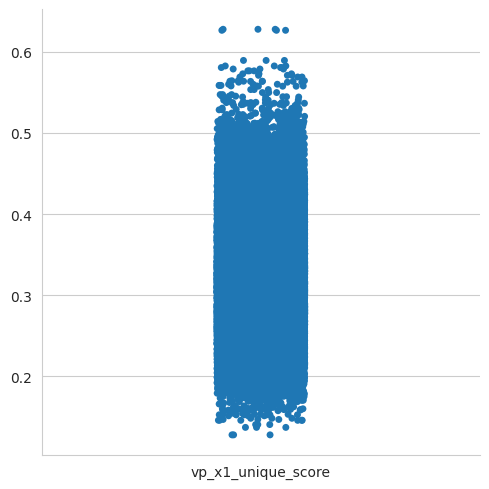

In [11]:
sns.catplot(data=pd.DataFrame(vp_x1_unique_predicted).T)